# Population based training (PBT)

Proposto em: https://arxiv.org/abs/1711.09846

In [1]:
# importando dependências
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sherpa
import math

In [2]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4
4,142.529999,138.050003,137.949997,131.740005,135.679993
5,144.229996,142.529999,138.050003,137.949997,131.740005
6,144.199997,144.229996,142.529999,138.050003,137.949997
7,143.800003,144.199997,144.229996,142.529999,138.050003
8,145.389999,143.800003,144.199997,144.229996,142.529999


In [3]:
#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

##### Criando modelos default

In [4]:
svm_default = SVR()
rf_default = RandomForestRegressor()
gdb_default = GradientBoostingRegressor()

##### Criando espaços hiperparamétricos

In [5]:
svm_hp = {sherpa.Choice('kernel',['rbf','linear']), 
          sherpa.Choice('gamma',['scale','auto']), 
          sherpa.Continuous('C',[0.1,1.0]), 
          sherpa.Continuous('epsilon',[0.1,0.9])}

rf_hp = {sherpa.Discrete('n_estimators',[30,750]), 
        sherpa.Choice('criterion',['mse','mae']), 
        sherpa.Discrete('min_samples_split',[2,15]),
        sherpa.Choice('max_features',['auto','sqrt','log2']), 
        sherpa.Choice('oob_score',[True,False]), 
        sherpa.Continuous('max_samples',[0.1,0.99])}

gdb_hp = {sherpa.Choice('loss',['ls','lad','huber','quantile']), 
            sherpa.Continuous('learning_rate',[0.05,0.9]),
            sherpa.Discrete('n_estimators',[15,500]),
            sherpa.Continuous('subsample',[0.3,1.0]), 
            sherpa.Choice('criterion', ['friedman_mse','mse','mae']), 
            sherpa.Choice('max_features',['auto','sqrt','log2']),
            sherpa.Continuous('alpha',[0.05, 0.99])}

##### Preparando para o pbt

In [6]:
svm_algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=10,
                                                      num_generations=10,
                                                      perturbation_factors=(0.8, 1.2),
                                                      parameter_range={'C': [0.0,0.9], 'epsilon':[0.0,0.99]})
svm_study = sherpa.Study(parameters=svm_hp,
                     algorithm=svm_algorithm,
                     disable_dashboard = True,
                     lower_is_better=False)

rf_algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=10,
                                                      num_generations=10,
                                                      perturbation_factors=(0.8, 1.2),
                                                      parameter_range={'max_samples': [0.0,0.99]})
rf_study = sherpa.Study(parameters=rf_hp,
                     algorithm=rf_algorithm,
                     disable_dashboard = True,
                     lower_is_better=False)

gdb_algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=10,
                                                      num_generations=10,
                                                      perturbation_factors=(0.8, 1.2),
                                                      parameter_range={'learning_rate': [0.0,0.98], 'subsample':[0.0,1.0],
                                                                      'alpha': [0, 0.99]})
gdb_study = sherpa.Study(parameters=gdb_hp,
                     algorithm=gdb_algorithm,
                     disable_dashboard = True,
                     lower_is_better=False)

##### Função pbt

In [7]:
def pbt_opt(model_name, study):
    for trial in study:
        generation = trial.parameters['generation']

        print("-"*100)
        print("Generation {}".format(generation))
        print("Trial ", trial.id, " with parameters ", trial.parameters)
        
        # Create model
        if(model_name == 'SVR'):
            model = SVR(C=trial.parameters['C'], epsilon = trial.parameters['epsilon'])
            
        elif(model_name == 'RF'):
            model = RandomForestRegressor(n_estimators=trial.parameters['n_estimators'], criterion = trial.parameters['criterion'],
                       min_samples_split=trial.parameters['min_samples_split'], max_features = trial.parameters['max_features'],
                       oob_score=trial.parameters['oob_score'], max_samples = trial.parameters['max_samples'])
            
        elif(model_name == 'GDB'):
            model = GradientBoostingRegressor(loss=trial.parameters['loss'], learning_rate = trial.parameters['learning_rate'],
                        n_estimators=trial.parameters['n_estimators'], subsample = trial.parameters['subsample'],
                        criterion=trial.parameters['criterion'], max_features = trial.parameters['max_features'],
                        alpha=trial.parameters['alpha'])
        else:
            print("ERROR - Model not found")
            
        # Train model for one epoch
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)

        print("Validation accuracy: ", score)
        study.add_observation(trial=trial, iteration=generation,
                              objective=score)
        study.finalize(trial=trial)
    return study.get_best_result()

##### Aplicando pbt nos modelos SVM, RF, GDB

In [8]:
svm_ini = time.time()
svm_results = pbt_opt("SVR",svm_study)
svm_fim = time.time()
print('-'*100)
print(svm_results)
print('-'*100)

----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'kernel': 'linear', 'C': 0.5804009948828324, 'gamma': 'scale', 'epsilon': 0.2430689399944572, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.7999846521087886
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'kernel': 'linear', 'C': 0.5375427439144251, 'gamma': 'scale', 'epsilon': 0.7353113847507672, 'lineage': '', 'load_from': '', 'save_to': '2', 'generation': 1}
Validation accuracy:  0.7885013199658543
----------------------------------------------------------------------------------------------------
Generation 1
Trial  3  with parameters  {'kernel': 'linear', 'C': 0.3224996550891692, 'gamma': 'auto', 'epsilon': 0.42110270297751695, 'lineage': '', 'load_from': '', 'save_to': '3', 'generation': 1}
Validation accu

Validation accuracy:  0.8455973490953532
----------------------------------------------------------------------------------------------------
Generation 4
Trial  31  with parameters  {'kernel': 'rbf', 'C': 0.9796075690925872, 'gamma': 'scale', 'epsilon': 0.16202712572249078, 'load_from': '21', 'save_to': '31', 'lineage': '10,11,21,', 'generation': 4}
Validation accuracy:  0.8540152714353739
----------------------------------------------------------------------------------------------------
Generation 4
Trial  32  with parameters  {'kernel': 'rbf', 'C': 0.9, 'gamma': 'scale', 'epsilon': 0.19443255086698893, 'load_from': '22', 'save_to': '32', 'lineage': '10,20,22,', 'generation': 4}
Validation accuracy:  0.8458501009981036
----------------------------------------------------------------------------------------------------
Generation 4
Trial  33  with parameters  {'kernel': 'rbf', 'C': 0.9, 'gamma': 'scale', 'epsilon': 0.23331906104038672, 'load_from': '29', 'save_to': '33', 'lineage': '

----------------------------------------------------------------------------------------------------
Generation 7
Trial  62  with parameters  {'kernel': 'linear', 'C': 0.9, 'gamma': 'auto', 'epsilon': 0.12962170057799263, 'load_from': '52', 'save_to': '62', 'lineage': '10,11,21,31,49,52,', 'generation': 7}
Validation accuracy:  0.8466274903369444
----------------------------------------------------------------------------------------------------
Generation 7
Trial  63  with parameters  {'kernel': 'linear', 'C': 0.9, 'gamma': 'auto', 'epsilon': 0.15554604069359115, 'load_from': '53', 'save_to': '63', 'lineage': '10,20,22,32,50,53,', 'generation': 7}
Validation accuracy:  0.8462067540246102
----------------------------------------------------------------------------------------------------
Generation 7
Trial  64  with parameters  {'kernel': 'rbf', 'C': 0.9, 'gamma': 'scale', 'epsilon': 0.19443255086698893, 'load_from': '54', 'save_to': '64', 'lineage': '10,20,22,32,42,54,', 'generation':

----------------------------------------------------------------------------------------------------
Generation 9
Trial  89  with parameters  {'kernel': 'linear', 'C': 0.7200000000000001, 'gamma': 'scale', 'epsilon': 0.15554604069359115, 'load_from': '72', 'save_to': '89', 'lineage': '10,11,21,31,49,52,62,72,', 'generation': 9}
Validation accuracy:  0.824669456999663
----------------------------------------------------------------------------------------------------
Generation 9
Trial  90  with parameters  {'kernel': 'rbf', 'C': 0.9, 'gamma': 'scale', 'epsilon': 0.12962170057799263, 'load_from': '71', 'save_to': '90', 'lineage': '10,11,21,31,41,51,61,71,', 'generation': 9}
Validation accuracy:  0.8466274903369444
----------------------------------------------------------------------------------------------------
Generation 10
Trial  91  with parameters  {'kernel': 'rbf', 'C': 0.9796075690925872, 'gamma': 'scale', 'epsilon': 0.16202712572249078, 'load_from': '81', 'save_to': '91', 'line

In [9]:
rf_ini = time.time()
rf_results = pbt_opt("RF",rf_study)
rf_fim = time.time()

----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'criterion': 'mae', 'min_samples_split': 5, 'n_estimators': 80, 'max_features': 'auto', 'oob_score': True, 'max_samples': 0.24056660520530915, 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.9442538798476301
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'criterion': 'mae', 'min_samples_split': 11, 'n_estimators': 609, 'max_features': 'sqrt', 'oob_score': False, 'max_samples': 0.9585367695816083, 'lineage': '', 'load_from': '', 'save_to': '2', 'generation': 1}
Validation accuracy:  0.9424563167878103
----------------------------------------------------------------------------------------------------
Generation 1
Trial  3  with parameters  {'criterion': 'mae', 'min_samples_split': 7, 'n_estimators': 371, 'max_feat

Validation accuracy:  0.9449819568458491
----------------------------------------------------------------------------------------------------
Generation 3
Trial  22  with parameters  {'criterion': 'mae', 'min_samples_split': 8, 'n_estimators': 129, 'max_features': 'log2', 'oob_score': False, 'max_samples': 0.600816184140343, 'load_from': '20', 'save_to': '22', 'lineage': '6,20,', 'generation': 3}
Validation accuracy:  0.9394759763432949
----------------------------------------------------------------------------------------------------
Generation 3
Trial  23  with parameters  {'criterion': 'mse', 'min_samples_split': 8, 'n_estimators': 194, 'max_features': 'log2', 'oob_score': True, 'max_samples': 0.600816184140343, 'load_from': '19', 'save_to': '23', 'lineage': '6,19,', 'generation': 3}
Validation accuracy:  0.9410770623825391
----------------------------------------------------------------------------------------------------
Generation 3
Trial  24  with parameters  {'criterion': 'mse

Validation accuracy:  0.9456983994832366
----------------------------------------------------------------------------------------------------
Generation 5
Trial  43  with parameters  {'criterion': 'mae', 'min_samples_split': 11, 'n_estimators': 609, 'max_features': 'sqrt', 'oob_score': False, 'max_samples': 0.9585367695816083, 'load_from': '36', 'save_to': '43', 'lineage': '2,13,25,36,', 'generation': 5}
Validation accuracy:  0.9415927004059181
----------------------------------------------------------------------------------------------------
Generation 5
Trial  44  with parameters  {'criterion': 'mae', 'min_samples_split': 6, 'n_estimators': 103, 'max_features': 'log2', 'oob_score': True, 'max_samples': 0.4806529473122744, 'load_from': '37', 'save_to': '44', 'lineage': '6,20,30,37,', 'generation': 5}
Validation accuracy:  0.9407274064566156
----------------------------------------------------------------------------------------------------
Generation 5
Trial  45  with parameters  {'c

Validation accuracy:  0.9455355571333832
----------------------------------------------------------------------------------------------------
Generation 7
Trial  64  with parameters  {'criterion': 'mae', 'min_samples_split': 11, 'n_estimators': 609, 'max_features': 'sqrt', 'oob_score': False, 'max_samples': 0.9585367695816083, 'load_from': '54', 'save_to': '64', 'lineage': '2,13,25,36,43,54,', 'generation': 7}
Validation accuracy:  0.9409004749240747
----------------------------------------------------------------------------------------------------
Generation 7
Trial  65  with parameters  {'criterion': 'mse', 'min_samples_split': 6, 'n_estimators': 380, 'max_features': 'auto', 'oob_score': True, 'max_samples': 0.8512361228781189, 'load_from': '56', 'save_to': '65', 'lineage': '10,15,24,34,45,56,', 'generation': 7}
Validation accuracy:  0.9415104140613839
----------------------------------------------------------------------------------------------------
Generation 7
Trial  66  with pa

Validation accuracy:  0.9467433280232803
----------------------------------------------------------------------------------------------------
Generation 9
Trial  84  with parameters  {'criterion': 'mae', 'min_samples_split': 11, 'n_estimators': 609, 'max_features': 'sqrt', 'oob_score': False, 'max_samples': 0.9585367695816083, 'load_from': '77', 'save_to': '84', 'lineage': '2,13,25,36,43,54,64,77,', 'generation': 9}
Validation accuracy:  0.941616371813226
----------------------------------------------------------------------------------------------------
Generation 9
Trial  85  with parameters  {'criterion': 'mse', 'min_samples_split': 6, 'n_estimators': 380, 'max_features': 'auto', 'oob_score': True, 'max_samples': 0.8512361228781189, 'load_from': '75', 'save_to': '85', 'lineage': '10,15,24,34,45,56,65,75,', 'generation': 9}
Validation accuracy:  0.9399468273235969
----------------------------------------------------------------------------------------------------
Generation 9
Trial  

In [10]:
print('-'*100)
print(rf_results)
print('-'*100)

----------------------------------------------------------------------------------------------------
{'Trial-ID': 61, 'Iteration': 7, 'criterion': 'mae', 'generation': 7, 'lineage': '6,11,21,31,41,51,', 'load_from': '51', 'max_features': 'auto', 'max_samples': 0.5006801534502858, 'min_samples_split': 11, 'n_estimators': 162, 'oob_score': True, 'save_to': '61', 'Objective': 0.9477056889140643}
----------------------------------------------------------------------------------------------------


In [11]:
gdb_ini = time.time()
gdb_results = pbt_opt("GDB",gdb_study)
gdb_fim = time.time()

----------------------------------------------------------------------------------------------------
Generation 1
Trial  1  with parameters  {'loss': 'quantile', 'n_estimators': 378, 'max_features': 'sqrt', 'learning_rate': 0.38087865060448467, 'alpha': 0.34611895315831387, 'subsample': 0.48307617577490003, 'criterion': 'friedman_mse', 'lineage': '', 'load_from': '', 'save_to': '1', 'generation': 1}
Validation accuracy:  0.9421878250497183
----------------------------------------------------------------------------------------------------
Generation 1
Trial  2  with parameters  {'loss': 'quantile', 'n_estimators': 358, 'max_features': 'sqrt', 'learning_rate': 0.15922197069730304, 'alpha': 0.5453650633605203, 'subsample': 0.5922252191200543, 'criterion': 'friedman_mse', 'lineage': '', 'load_from': '', 'save_to': '2', 'generation': 1}
Validation accuracy:  0.9465142142162476
----------------------------------------------------------------------------------------------------
Generation 1


Validation accuracy:  0.9124894152483004
----------------------------------------------------------------------------------------------------
Generation 2
Trial  20  with parameters  {'loss': 'huber', 'n_estimators': 286, 'max_features': 'log2', 'learning_rate': 0.19106636483676365, 'alpha': 0.43629205068841626, 'subsample': 0.4737801752960435, 'criterion': 'mae', 'load_from': '2', 'save_to': '20', 'lineage': '2,', 'generation': 2}
Validation accuracy:  0.9388239905378174
----------------------------------------------------------------------------------------------------
Generation 3
Trial  21  with parameters  {'loss': 'quantile', 'n_estimators': 358, 'max_features': 'sqrt', 'learning_rate': 0.15922197069730304, 'alpha': 0.5453650633605203, 'subsample': 0.5922252191200543, 'criterion': 'friedman_mse', 'load_from': '11', 'save_to': '21', 'lineage': '2,11,', 'generation': 3}
Validation accuracy:  0.9261290550669736
------------------------------------------------------------------------

Validation accuracy:  0.9385960497455638
----------------------------------------------------------------------------------------------------
Generation 4
Trial  39  with parameters  {'loss': 'lad', 'n_estimators': 175, 'max_features': 'sqrt', 'learning_rate': 0.37190376416091553, 'alpha': 0.5724494492848863, 'subsample': 0.8660410529503949, 'criterion': 'mae', 'load_from': '26', 'save_to': '39', 'lineage': '6,15,26,', 'generation': 4}
Validation accuracy:  0.9199672517887764
----------------------------------------------------------------------------------------------------
Generation 4
Trial  40  with parameters  {'loss': 'huber', 'n_estimators': 343, 'max_features': 'log2', 'learning_rate': 0.15285309186941093, 'alpha': 0.34903364055073305, 'subsample': 0.5685362103552521, 'criterion': 'mse', 'load_from': '22', 'save_to': '40', 'lineage': '2,20,22,', 'generation': 4}
Validation accuracy:  0.9454649193586306
----------------------------------------------------------------------------

Validation accuracy:  0.9506470482474374
----------------------------------------------------------------------------------------------------
Generation 6
Trial  58  with parameters  {'loss': 'lad', 'n_estimators': 481, 'max_features': 'log2', 'learning_rate': 0.11729831016054126, 'alpha': 0.5417834217254031, 'subsample': 0.34638011099495936, 'criterion': 'mse', 'load_from': '43', 'save_to': '58', 'lineage': '8,14,23,35,43,', 'generation': 6}
Validation accuracy:  0.9364833987885213
----------------------------------------------------------------------------------------------------
Generation 6
Trial  59  with parameters  {'loss': 'lad', 'n_estimators': 219, 'max_features': 'auto', 'learning_rate': 0.22010845229195172, 'alpha': 0.5026084423930556, 'subsample': 0.545794761941042, 'criterion': 'mse', 'load_from': '49', 'save_to': '59', 'lineage': '2,20,22,40,49,', 'generation': 6}
Validation accuracy:  0.9422614350198941
-------------------------------------------------------------------

Validation accuracy:  0.9288085650119051
----------------------------------------------------------------------------------------------------
Generation 8
Trial  78  with parameters  {'loss': 'ls', 'n_estimators': 286, 'max_features': 'sqrt', 'learning_rate': 0.19106636483676365, 'alpha': 0.43629205068841626, 'subsample': 0.4737801752960435, 'criterion': 'friedman_mse', 'load_from': '67', 'save_to': '78', 'lineage': '2,11,30,36,46,54,67,', 'generation': 8}
Validation accuracy:  0.9363482900598401
----------------------------------------------------------------------------------------------------
Generation 8
Trial  79  with parameters  {'loss': 'huber', 'n_estimators': 429, 'max_features': 'sqrt', 'learning_rate': 0.19106636483676365, 'alpha': 0.6544380760326243, 'subsample': 0.7106702629440652, 'criterion': 'friedman_mse', 'load_from': '64', 'save_to': '79', 'lineage': '2,11,21,38,44,55,64,', 'generation': 8}
Validation accuracy:  0.9334110126891676
-----------------------------------

Validation accuracy:  0.9437294942834625
----------------------------------------------------------------------------------------------------
Generation 10
Trial  96  with parameters  {'loss': 'huber', 'n_estimators': 175, 'max_features': 'auto', 'learning_rate': 0.2641301427503421, 'alpha': 0.6031301308716667, 'subsample': 0.43663580955283365, 'criterion': 'mae', 'load_from': '87', 'save_to': '96', 'lineage': '2,20,22,40,49,59,63,80,87,', 'generation': 10}
Validation accuracy:  0.9393879508014951
----------------------------------------------------------------------------------------------------
Generation 10
Trial  97  with parameters  {'loss': 'huber', 'n_estimators': 429, 'max_features': 'sqrt', 'learning_rate': 0.19106636483676365, 'alpha': 0.6544380760326243, 'subsample': 0.7106702629440652, 'criterion': 'friedman_mse', 'load_from': '88', 'save_to': '97', 'lineage': '2,11,21,38,44,55,64,79,88,', 'generation': 10}
Validation accuracy:  0.9383698215087743
--------------------------

In [12]:
print('-'*100)
print(gdb_results)
print('-'*100)

----------------------------------------------------------------------------------------------------
{'Trial-ID': 63, 'Iteration': 7, 'alpha': 0.5026084423930556, 'criterion': 'mse', 'generation': 7, 'learning_rate': 0.22010845229195172, 'lineage': '2,20,22,40,49,59,', 'load_from': '59', 'loss': 'lad', 'max_features': 'auto', 'n_estimators': 219, 'save_to': '63', 'subsample': 0.545794761941042, 'Objective': 0.9514732780890737}
----------------------------------------------------------------------------------------------------


##### Criando modelos ajustados

In [13]:
svm_tuned = SVR(C=svm_results['C'], epsilon = svm_results['epsilon'])

rf_tuned = RandomForestRegressor(n_estimators=rf_results['n_estimators'], criterion = rf_results['criterion'],
                       min_samples_split=rf_results['min_samples_split'], max_features = rf_results['max_features'],
                       oob_score=rf_results['oob_score'], max_samples = rf_results['max_samples'])

gdb_tuned = GradientBoostingRegressor(loss=gdb_results['loss'], learning_rate = gdb_results['learning_rate'],
                        n_estimators=gdb_results['n_estimators'], subsample =gdb_results['subsample'],
                        criterion=gdb_results['criterion'], max_features = gdb_results['max_features'],
                        alpha=gdb_results['alpha'])

##### Treinando modelos

In [14]:
#Modelos padrão
svm_default.fit(X_train,y_train)
rf_default.fit(X_train,y_train)
gdb_default.fit(X_train,y_train)

#Modelos ajustados
svm_tuned.fit(X_train,y_train)
rf_tuned.fit(X_train,y_train)
gdb_tuned.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.5026084423930556, criterion='mse',
                          learning_rate=0.22010845229195172, loss='lad',
                          max_features='auto', n_estimators=219,
                          subsample=0.545794761941042)

##### Recolhendo pontuações

In [15]:
#Modelos padrão
svm_default_score = svm_default.score(X_test,y_test)
rf_default_score = rf_default.score(X_test,y_test)
gdb_default_score = gdb_default.score(X_test,y_test)

#Modelos ajustados
svm_tuned_score = svm_tuned.score(X_test,y_test)
rf_tuned_score = rf_tuned.score(X_test,y_test)
gdb_tuned_score = gdb_tuned.score(X_test,y_test)

##### Recolhendo previsões

In [16]:
#Modelos padrão
svm_default_pred = svm_default.predict(X)
rf_default_pred = rf_default.predict(X)
gdb_default_pred = gdb_default.predict(X)

#Modelos ajustados
svm_tuned_pred = svm_tuned.predict(X)
rf_tuned_pred = rf_tuned.predict(X)
gdb_tuned_pred = gdb_tuned.predict(X)

##### Relatório

In [17]:
print('--RELATÓRIO--')

print('SVM:')
print('Default score: ',svm_default_score)
print('Tuned score: ',svm_tuned_score)
print('Time (s): ', svm_fim-svm_ini)
print('--------------------')

print('RF:')
print('Default score: ',rf_default_score)
print('Tuned score: ',rf_tuned_score)
print('Time (s): ', rf_fim-rf_ini)
print('--------------------')

print('Gradient Boosting:')
print('Default score: ',gdb_default_score)
print('Tuned score: ',gdb_tuned_score)
print('Time (s): ', gdb_fim-gdb_ini)
print('--------------------')

--RELATÓRIO--
SVM:
Default score:  0.85605189803503
Tuned score:  0.8540152714353739
Time (s):  2.38940167427063
--------------------
RF:
Default score:  0.9372726645003102
Tuned score:  0.9457218818044185
Time (s):  51.8387656211853
--------------------
Gradient Boosting:
Default score:  0.9437446384088678
Tuned score:  0.9432351606528644
Time (s):  43.58294868469238
--------------------


In [18]:
# Pegando maior pontuação
scores = []
scores.append(svm_default_score)
scores.append(svm_tuned_score)
scores.append(rf_default_score)
scores.append(rf_tuned_score)
scores.append(gdb_default_score)
scores.append(gdb_tuned_score)

max_score = max(scores)
print(max_score)

0.9457218818044185


##### Visualizando resultados

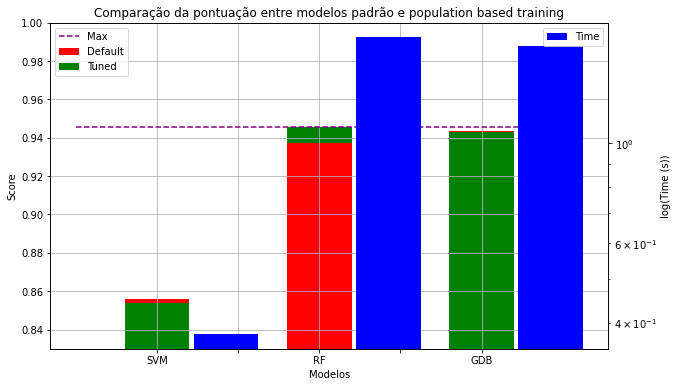

In [19]:
#Visualizando resultados

#plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(0, svm_default_score, color='red', label='Default')
ax1.bar(0, svm_tuned_score, color='green', label='Tuned')

ax1.bar(2, rf_tuned_score, color='green')
ax1.bar(2, rf_default_score, color='red')

ax1.bar(4, gdb_default_score, color='red')
ax1.bar(4, gdb_tuned_score, color='green')

ax1.set_ylim(0.83, 1.0)
ax1.set_ylabel('Score')
ax1.set_xlabel('Modelos')
ax1.set_title('Comparação da pontuação entre modelos padrão e population based training')

ax1.hlines(max_score, -1, 5, colors='purple', linestyles='--', label='Max')

ax1.legend(loc='upper left')

ax1.grid()

# Plotando tempos
ax2 = ax1.twinx()

ax2.bar(0.85, math.log(svm_fim-svm_ini,10), color='blue', label='Time')
ax2.bar(2.85, math.log(rf_fim-rf_ini,10), color='blue')
ax2.bar(4.85, math.log(gdb_fim-gdb_ini,10), color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('log(Time (s))')
ax2.legend(loc='upper right')


plt.xticks(np.arange(5),['SVM','','RF','','GDB'])
plt.show()